<a href="https://colab.research.google.com/github/ryan73093/kaggle-sklearn/blob/main/Predicting_Churn_for_Bank_Customers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers

In [36]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import random
import warnings
warnings.filterwarnings("ignore")


In [37]:
from google.colab import drive
drive.mount('/content/drive')##出現提示欄進行授權
os.chdir('/content/drive/My Drive/Colab Notebooks/kaggle-sklearn') #切換該目錄
os.listdir() #確認目錄內容

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['libs',
 'data',
 'catboost_info',
 'sklearn_classifier.ipynb',
 'sklearn_regression.ipynb',
 '.gitignore',
 'classifier_heart_failure.ipynb',
 'Predicting_Churn_for_Bank_Customers.ipynb']

In [80]:
df_set = pd.read_csv('data/Churn_Modelling.csv')
print(df_set.head())

   RowNumber  CustomerId   Surname  ...  IsActiveMember EstimatedSalary Exited
0          1    15634602  Hargrave  ...               1       101348.88      1
1          2    15647311      Hill  ...               1       112542.58      0
2          3    15619304      Onio  ...               0       113931.57      1
3          4    15701354      Boni  ...               0        93826.63      0
4          5    15737888  Mitchell  ...               1        79084.10      0

[5 rows x 14 columns]


In [84]:
TARGET='Exited'

df_feature=df_set.drop(columns=[TARGET])
df_target=df_set[TARGET]
df=pd.concat([df_feature,df_target],axis=1)
print(df.head())

   RowNumber  CustomerId   Surname  ...  IsActiveMember EstimatedSalary Exited
0          1    15634602  Hargrave  ...               1       101348.88      1
1          2    15647311      Hill  ...               1       112542.58      0
2          3    15619304      Onio  ...               0       113931.57      1
3          4    15701354      Boni  ...               0        93826.63      0
4          5    15737888  Mitchell  ...               1        79084.10      0

[5 rows x 14 columns]


Feature Analysis

In [82]:
print(df['Geography'].drop_duplicates())
print(df['Gender'].drop_duplicates())

0     France
1      Spain
7    Germany
Name: Geography, dtype: object
0    Female
5      Male
Name: Gender, dtype: object


In [85]:
df_mlp = df[['CreditScore','Age','Tenure','Balance','NumOfProducts','IsActiveMember','EstimatedSalary','Exited']]
df_ = df[['Age','Balance','NumOfProducts','HasCrCard','IsActiveMember','Exited']]


## Analysis

In [ ]:
from libs.SeabornFig2Grid import SeabornFig2Grid
import matplotlib.gridspec as gridspec
#增強資料可視性
lst_tmp=[]
for i in range(len(df)):
  lst_tmp.append(random.uniform(-0.1,0.1))
df_plt=df.copy()
df_plt[TARGET]=df[TARGET]+lst_tmp
#繪製
for i in range(math.ceil(len(df_feature.columns)/4)):
  fig=plt.figure(figsize=(20,5))
  gs=gridspec.GridSpec(1, 4)
  for j in range(4):
    try:
      fig_tmp=sns.jointplot(x=list(df_feature)[(4*i+j)],y=TARGET,data=df_plt,kind='reg')
      mg=SeabornFig2Grid(fig_tmp, fig, gs[j])
    except IndexError:
      continue     
  gs.tight_layout(fig)
  plt.show()

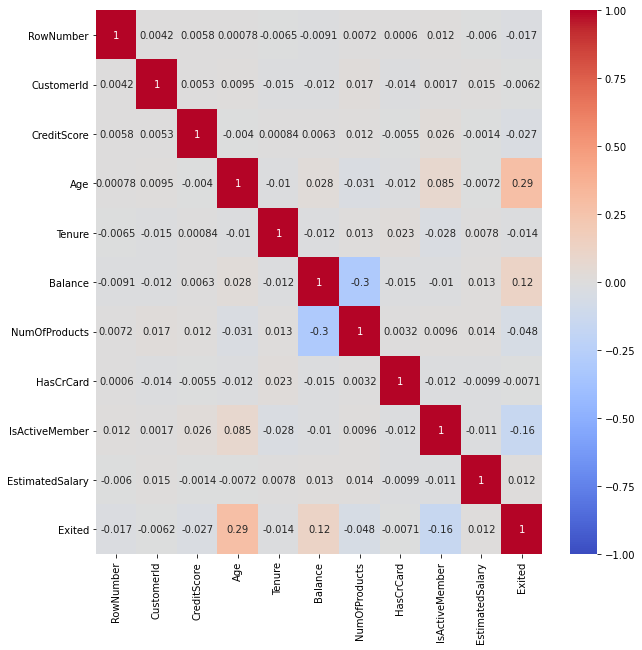

In [87]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), vmin=-1, cmap='coolwarm', annot=True)

## Feature Select

In [ ]:
df=df[['ejection_fraction','serum_creatinine','time',TARGET]]
print(df.head())

## Training Prepare

In [76]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
def training(df,method,scaler=None,fig_amount_show=100):
    # Training set & Testing set
    X = df[df.columns[:-1]].values
    Y = df[df.columns[-1]].values
    train_X,test_X,train_Y,test_Y=train_test_split(X,Y,test_size=0.1, random_state=0)
    X.mean()

    classifier = method
    if scaler=='minmax':
        sc = MinMaxScaler()
        sc.fit(train_X)
        train_X_ = sc.transform(train_X)
        test_X_ = sc.transform(test_X)
    elif scaler=='std':
        sc = StandardScaler()
        sc.fit(train_X)
        train_X_ = sc.transform(train_X)
        test_X_ = sc.transform(test_X)
    else:
        train_X_ = train_X
        test_X_ = test_X

    classifier.fit(train_X_, train_Y)
    print(classifier.fit(train_X_, train_Y))

    pred_Y = classifier.predict(test_X_)
    test_prob=np.ravel(classifier.predict_proba(test_X_)[:,[1]])
    df_pred = pd.DataFrame({'Actual': test_Y, 'Predicted': pred_Y,'Probability':test_prob}).round(3)
    df_pred['Error']=df_pred['Predicted']-df_pred['Actual']
    try:
      df_pred=df_pred.iloc[random.sample(df_pred.index.tolist(), fig_amount_show)] 
    except ValueError:
      print("Your data is smaller than fig_amount_show's setting. ")
    df_pred=df_pred.sort_values(by='Actual').reset_index(drop=True)   
    max_value=max([df_pred['Actual'].max(),df_pred['Predicted'].max()])
    


    #plot
    plt.figure(figsize=(25,3))
    plt.bar(df_pred.index,df_pred['Probability'],width=0.5,zorder=1)
    plt.bar(df_pred[df_pred['Error']!=0].index,df_pred[df_pred['Error']!=0]['Probability'],width=0.5,zorder=1,color='r')
    plt.scatter(df_pred.index,df_pred['Predicted'],c='r',s=12,zorder=3)
    plt.scatter(df_pred.index,df_pred['Actual'],zorder=2,c='g')
    plt.xticks(df_pred.index,df_pred['Probability'].round(3),rotation=90)
    plt.legend(['predict','actual','prob','Predict_error prob'])
    plt.grid() 
    plt.show()

    print('Accuracy Score:', round(metrics.accuracy_score(test_Y,pred_Y,normalize=True),4))

## Training

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


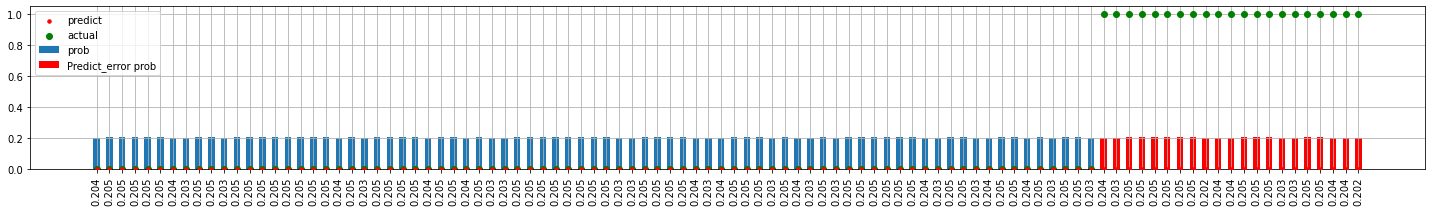

Accuracy Score: 0.794


In [86]:
from sklearn.svm import SVC
training(df_, SVC(probability=True),scaler='mimax')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


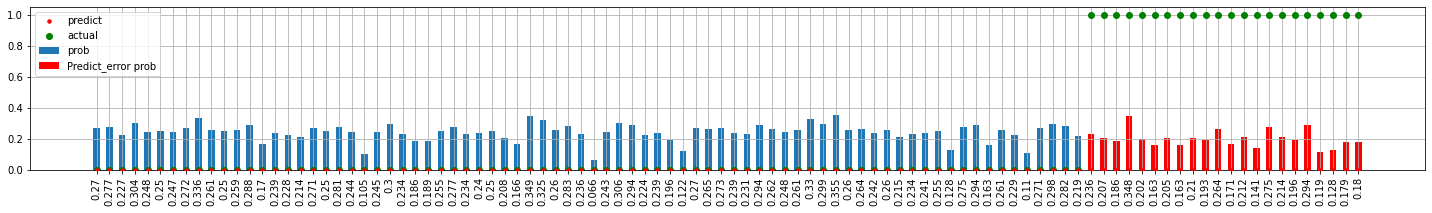

Accuracy Score: 0.794


In [88]:
from sklearn.linear_model import LogisticRegression
training(df_, LogisticRegression())

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


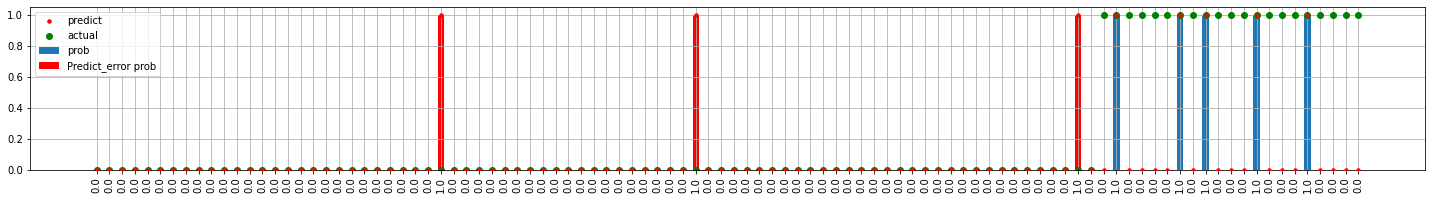

Accuracy Score: 0.782


In [89]:
from sklearn.linear_model import SGDClassifier
training(df_, SGDClassifier(loss='modified_huber'))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


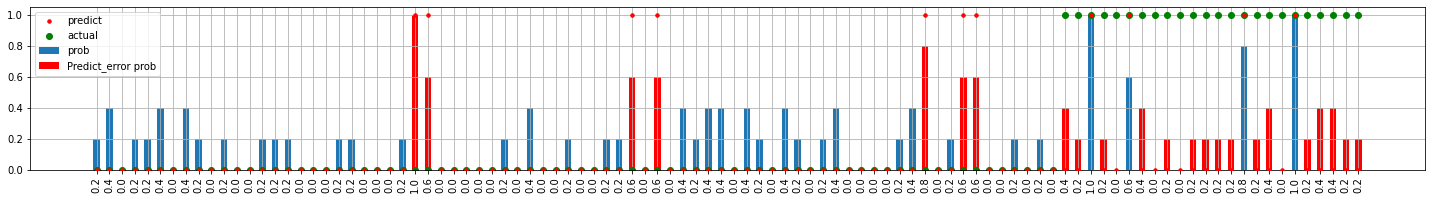

Accuracy Score: 0.774


In [90]:
from sklearn.neighbors import KNeighborsClassifier
training(df_, KNeighborsClassifier())

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


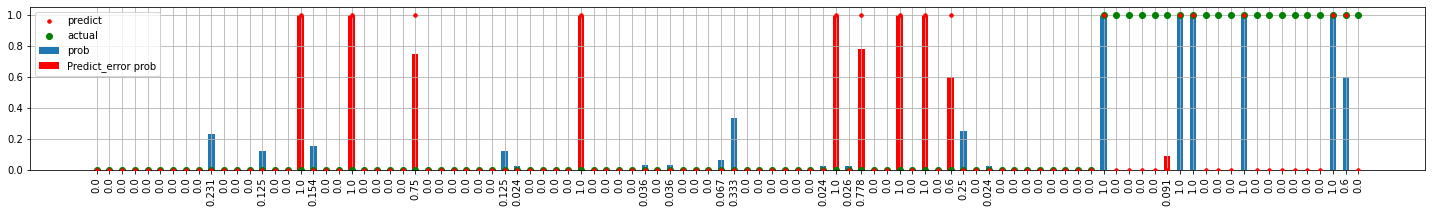

Accuracy Score: 0.787


In [91]:
from sklearn.tree import DecisionTreeClassifier
training(df_, DecisionTreeClassifier(), scaler='mimax')

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


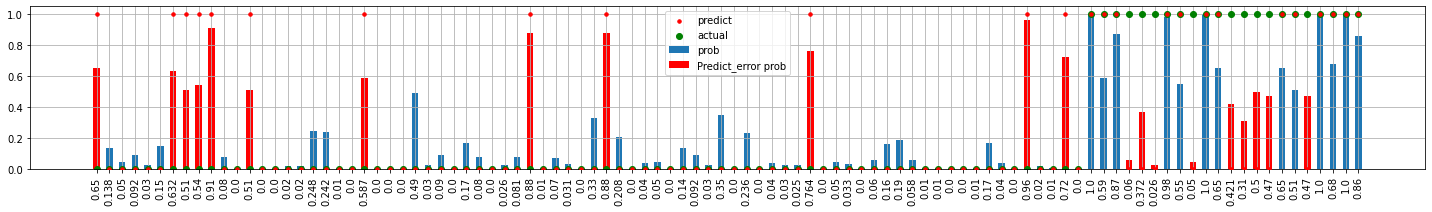

Accuracy Score: 0.811


In [92]:
from sklearn.ensemble import RandomForestClassifier
training(df_, RandomForestClassifier())

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)


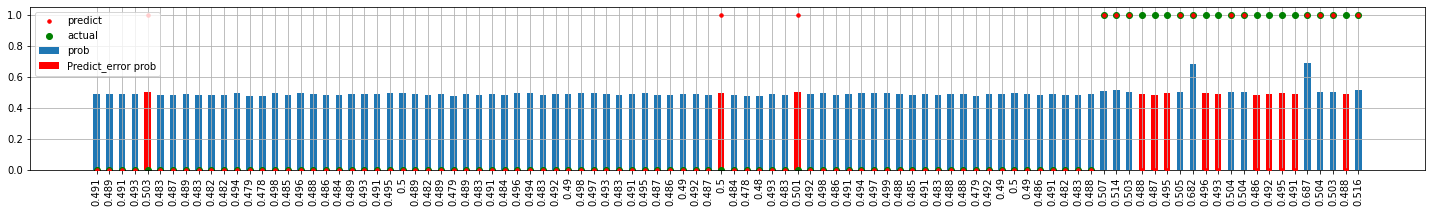

Accuracy Score: 0.846


In [93]:
from sklearn.ensemble import AdaBoostClassifier
training(df_, AdaBoostClassifier())

Iteration 1, loss = 0.51455776
Iteration 2, loss = 0.51238590
Iteration 3, loss = 0.51066475
Iteration 4, loss = 0.50930455
Iteration 5, loss = 0.50823356
Iteration 6, loss = 0.50743186
Iteration 7, loss = 0.50682250
Iteration 8, loss = 0.50634353
Iteration 9, loss = 0.50600501
Iteration 10, loss = 0.50574800
Iteration 11, loss = 0.50556139
Iteration 12, loss = 0.50543108
Iteration 13, loss = 0.50534012
Iteration 14, loss = 0.50528642
Iteration 15, loss = 0.50523368
Iteration 16, loss = 0.50520617
Iteration 17, loss = 0.50519305
Iteration 18, loss = 0.50517534
Iteration 19, loss = 0.50515985
Iteration 20, loss = 0.50516135
Iteration 21, loss = 0.50515159
Iteration 22, loss = 0.50515830
Iteration 23, loss = 0.50515053
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.63201747
Iteration 2, loss = 0.51696587
Iteration 3, loss = 0.49510383
Iteration 4, loss = 0.49263213
Iteration 5, loss = 0.49023105
Iteration 6, loss = 0.487523

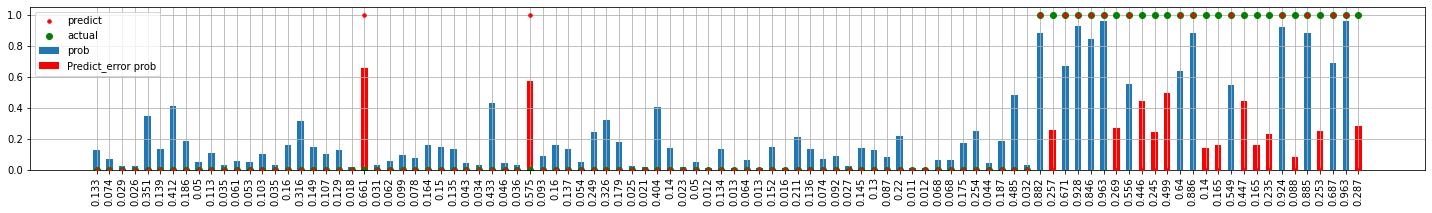

Accuracy Score: 0.859


In [94]:
from sklearn.neural_network import MLPClassifier
training(df_mlp, MLPClassifier(hidden_layer_sizes=(8,8,8,4,2),verbose=True,max_iter=250), scaler='minmax')

Learning rate set to 0.026327
0:	learn: 0.6709512	total: 5.61ms	remaining: 5.6s
1:	learn: 0.6517849	total: 9.73ms	remaining: 4.86s
2:	learn: 0.6321496	total: 14.4ms	remaining: 4.78s
3:	learn: 0.6194332	total: 17.7ms	remaining: 4.4s
4:	learn: 0.6023971	total: 22.4ms	remaining: 4.46s
5:	learn: 0.5865222	total: 26.8ms	remaining: 4.44s
6:	learn: 0.5710184	total: 31.3ms	remaining: 4.43s
7:	learn: 0.5590206	total: 34.9ms	remaining: 4.33s
8:	learn: 0.5466506	total: 39.7ms	remaining: 4.37s
9:	learn: 0.5348190	total: 44.1ms	remaining: 4.37s
10:	learn: 0.5230362	total: 48.7ms	remaining: 4.38s
11:	learn: 0.5141205	total: 53.1ms	remaining: 4.37s
12:	learn: 0.5033827	total: 57.8ms	remaining: 4.38s
13:	learn: 0.4941117	total: 62.3ms	remaining: 4.39s
14:	learn: 0.4853357	total: 67ms	remaining: 4.4s
15:	learn: 0.4768326	total: 71.6ms	remaining: 4.41s
16:	learn: 0.4696561	total: 76.2ms	remaining: 4.4s
17:	learn: 0.4625889	total: 80.7ms	remaining: 4.4s
18:	learn: 0.4553150	total: 85.3ms	remaining: 4.4s


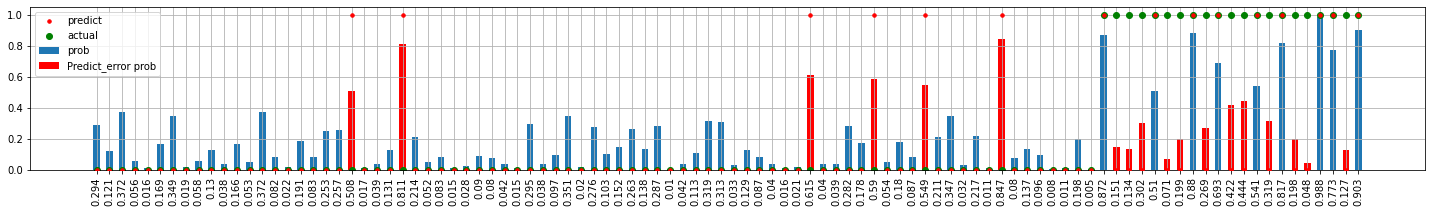

Accuracy Score: 0.856


In [95]:
!pip install catboost
from catboost import CatBoostClassifier
training(df_,CatBoostClassifier())